# Visualising XDMF files

In this tutorial, we will learn how to visualise the fields generated by FESTIM and exported to XDMF.

The problem for this tutorial will be the same as in ["Post-processing with FESTIM: derived quantities"](https://github.com/RemDelaporteMathurin/FESTIM/blob/master/demos/demo_derived_quantities.ipynb) with modified exports.


## 1. Implementation

In [1]:
from FESTIM import t
from FESTIM.generic_simulation import run
from fenics import Point, RectangleMesh, CompiledSubDomain, MeshFunction

# creating a 2D mesh with FEniCS
nx = ny = 14
mesh_fenics = RectangleMesh(Point(0, 0), Point(1e-7, 1e-7), nx, ny)

# marking volumes
volume_markers = MeshFunction("size_t", mesh_fenics, mesh_fenics.topology().dim())

volume_markers.set_all(1)

tol = 1e-14

subdomain_2 = CompiledSubDomain('x[1] >= 0.5e-7 - tol && x[0] >= 0.5e-7 - tol', tol=tol)
subdomain_2.mark(volume_markers, 2)

# marking surfaces
surface_markers = MeshFunction("size_t", mesh_fenics, mesh_fenics.topology().dim() - 1)

left_surface = CompiledSubDomain('on_boundary && near(x[0], 0, tol)',
                                tol=tol)
bottom_surface = CompiledSubDomain('on_boundary && near(x[1], 0, tol)',
                                     tol=tol)
surface_markers.set_all(0)
left_surface.mark(surface_markers, 1)
bottom_surface.mark(surface_markers, 2)

# creating mesh with FESTIM
parameters = {}
parameters["mesh_parameters"] = {
    "mesh": mesh_fenics,
    "volume_markers": volume_markers,
    "surface_markers": surface_markers,
}
parameters["materials"] = [{
    "E_D": 0.39,
    "D_0": 4.1e-7,
    "id": 1
},
    {
    "E_D": 0.5,
    "D_0": 5e-7,
    "id": 2
},
]
parameters["traps"] = [
        {
            "k_0": 3.8e-17,
            "E_k": 0.39,
            "p_0": 1e13,
            "E_p": 0.87,
            "density": 6e25,
            "materials": [1]
        },
        {
            "k_0": 3.8e-17,
            "E_k": 0.39,
            "p_0": 1e13,
            "E_p": 1.0,
            "density": 5e24,
            "materials": [2]
        },
]
parameters["boundary_conditions"] = [
            {
                "surfaces": [1],
                "value": 1e15,
                "type": "dc"
            },
            {
                "surfaces": [2],
                "value": 0,
                "type": "dc"
            },
]
parameters["temperature"] = {
    "type": "expression",
    "value": 400 + 3*t
}
parameters["solving_parameters"] = {
    "final_time": 10,
    "initial_stepsize": 0.005,
    "adaptive_stepsize": {
        "stepsize_change_ratio": 1.1,
        "dt_min": 1e-5
    },
    "newton_solver": {
        "absolute_tolerance": 1e0,
        "relative_tolerance": 1e-9,
        "maximum_iterations": 50,
    },
    "traps_element_type": "DG",
}
parameters["exports"] = {
    "derived_quantities": {
        "folder": 'solution_derived_quantities',
        "file": "derived_quantities.csv",
        "total_volume": [
            {
                "field": "retention",
                "volumes": [1, 2]
            },
        ],

    },
    "xdmf": {
        "functions": ['solute', '1', '2', 'retention'],
        "labels":  ['solute', '1', '2', 'retention'],
        "folder": "fields"
    }
}

output = run(parameters)

Defining initial values
Defining variational problem
Defining boundary conditions
Time stepping...


## 2. Field visualisation in python

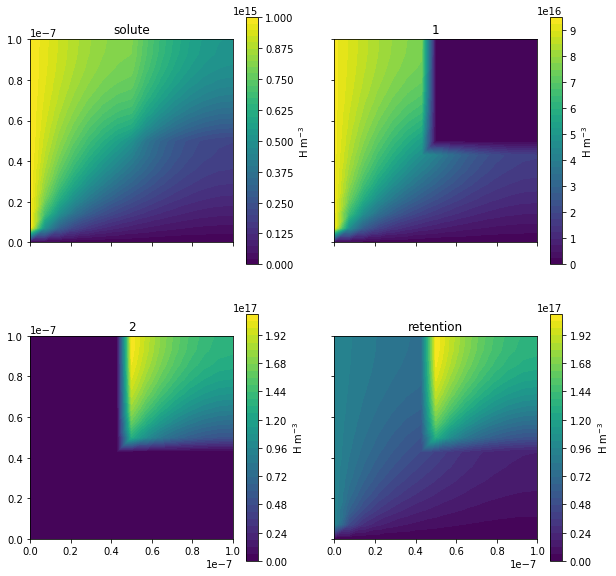

In [2]:
from fenics import XDMFFile, FunctionSpace, Function, plot, Mesh
import matplotlib.pyplot as plt


def load_field(mesh, fieldfile, field, counter=-1):
    """Loads a field from a XDMF file
    Args:
        mesh (fenics.Mesh): the mesh of the solution
        fieldfile (str): path of the XDMF file containing the field
        field (str): value of the field in the XDMF file
        counter (int, optionnal): timestep of the desired snapshot.
            -1 will return the last timestep. Defaults to -1.
    Returns:
        fenics.Function: the Function of the field
    """
    V = FunctionSpace(mesh, "DG", 1)
    u = Function(V)

    XDMFFile(fieldfile).read_checkpoint(u, field, counter)
    return u


# get the mesh from the output
mesh = output["mesh"]

# alternatively
mesh_file = XDMFFile("fields/mesh.xdmf")
mesh_file.write(output["mesh"]) # export the mesh as a XDMFFile
mesh = Mesh()  # create an empty mesh
mesh_file.read(mesh)  # read the XDMF file

# plot
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, sharex=True, sharey=True, figsize=(10, 10))

for fieldname, ax in zip(["solute", "1", "2", "retention"], [ax1, ax2, ax3, ax4]):
    field = load_field(mesh, "fields/" + fieldname + ".xdmf", fieldname)
    plt.sca(ax)
    ax.set_title(fieldname)
    cs = plot(field)
    cb = fig.colorbar(cs, label="H m$^{-3}$")

plt.show()

### Plot several timesteps

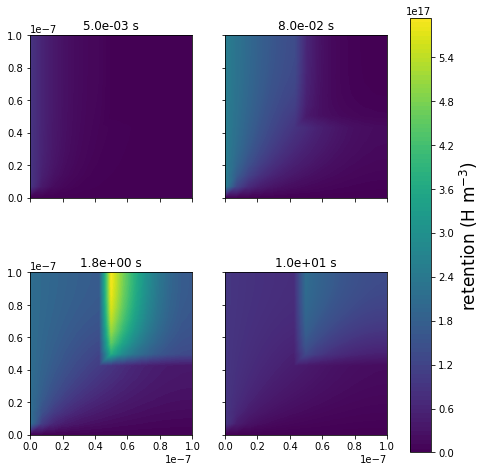

In [3]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, sharey=True, sharex=True, figsize=(8, 8))

axs = [ax1, ax2, ax3, ax4]

for counter, ax in zip([0, 9, 37, 55], axs):
    field = load_field(mesh, "fields/retention.xdmf", "retention", counter=counter)
    plt.sca(ax)
    time = output["derived_quantities"][1 + counter][0]
    ax.set_title("{:.1e} s".format(time))
    cs = plot(field, vmax=6e17, levels=100)
    if counter == 37:
        cb = plt.colorbar(cs, ax=axs)
cb.set_label(r'retention (H m$^{-3}$)', fontsize=17)
plt.show()

### Additionnal features

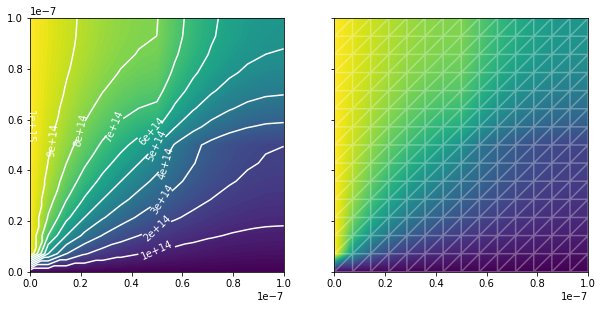

In [4]:
fig, axs = plt.subplots(1, 2, sharey=True, figsize=(10, 10))

# load last solute field
solute = load_field(mesh, "fields/solute.xdmf", "solute")

# plot solute with isovalues
plt.sca(axs[0])
plot(solute, levels=100)
# plot isovalues
CS = plot(solute, mode="contour", levels=10, colors="white")
CL = plt.clabel(CS, inline=True, fmt='%.e')

# plot solute with mesh
plt.sca(axs[1])
plot(solute, levels=100)
plot(mesh, color="white", alpha=0.3)

plt.show()

## External tools
You may have notice that when plotting with matplotlib, the fields are projected onto a continuous function space.

However, for higher quality images, especially when dealing with discontinuities (like it's the case for traps and retention here) we recommand to use an external viewer such as **Paraview** which can deal with finite elements data.
See for example the retention plotted with Paraview:

 <p align="center">
  <img src="https://user-images.githubusercontent.com/40028739/104925812-976b5d00-599f-11eb-9a93-92edda733ae1.png" width="40%">
</p>
